# Single sensor MTT with Field of View (FoV)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import scipy.linalg
from numpy.linalg import inv
import copy
from scipy.stats import multivariate_normal
from scipy.stats.distributions import chi2
from numpy import linalg as LA
from matplotlib.patches import Ellipse
import math
import time

## 1. Generate observation data

Sensor's location is (25, 25). 
Here we will have 3 tracking for 3 objects doing:
    1. sin wave movement
    2. linear movement: y = x
    3. Parabola: y = 0.4*(x - 25)^2 + 13 //y = 0.4*(x - 25)^2 + 15

In [30]:
input_var = 0.1
dt = 0.1
time_range = np.linspace(dt, 20, 200)

obs_list = []
random.seed(1)
traj1 = {"curve": 'sin','time_interval': [0, 20], "points": []}
traj2 = {"curve": 'line','time_interval': [0, 20], "points": []}
traj3 = {"curve": 'parabolic','time_interval': [0, 20], "points": []}
traj = [traj1, traj2, traj3]
noise = []
for traj_ in traj:
    [t0, t1] = traj_["time_interval"]
    if np.isclose(t0, 0):
        t0 = dt
    traj_["time_range"] = np.linspace(t0, t1, int(np.floor(t1/dt - t0/dt)) + 1)

def inside_time_interval(t, interval):
    if t >= interval[0]:
        if t <= interval[1]:
            return True
    return False

for t in time_range:
    # the sin wave signal
    z_k = []
    noise_k = []
    x = t + 15

    if inside_time_interval(t, traj[0]["time_interval"]):

        point_sin = [x + 0.1 *np.random.normal(0, input_var), 3 * np.sin(x) + 0.1 * np.random.normal(0, input_var) + 25]
        traj[0]["points"].append(point_sin)
        z_k.append(point_sin)
    
    if inside_time_interval(t, traj[1]["time_interval"]):
        point = [x + 0.1 *np.random.normal(0, input_var), x + 0.1 *np.random.normal(0, input_var)]
        traj[1]["points"].append(point)
        z_k.append(point)
    
    if inside_time_interval(t, traj[2]["time_interval"]):
#         point = [x + 0.1 *np.random.normal(0, input_var),  0.4*(x - 25)**2 + 13 + 0.1 *np.random.normal(0, input_var)]
        point = [x + 0.1 *np.random.normal(0, input_var),  0.4*(x - 25)**2 + 14.8 + 0.1 *np.random.normal(0, input_var)]
        traj[2]["points"].append(point)
        z_k.append(point)

    
    for i in range(random.randint(5, 10)):
        ran_point = [30* random.random() + 10, 30* random.random() + 10]
        noise_k.append(ran_point)

    noise.append(noise_k)
    z_k += noise_k
        
    obs_list.append(z_k)

In [3]:
# input for sensor parameter: 
sensor_pos = [25, 25]
shape = ["circle", [10]]
sensor_para = {"position": sensor_pos, 
              "shape": shape}

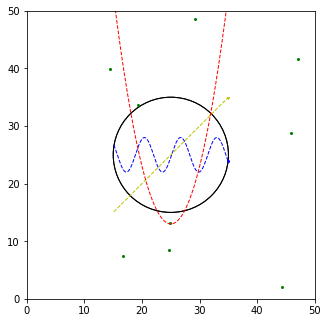

In [36]:
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0, 50), ylim=(0, 50))

real_point1, = ax.plot([], [], 'bo', ms=2)
real_point2, = ax.plot([], [], 'yv', ms=2)
real_point3, = ax.plot([], [], 'r*', ms=2)
rand_point, = ax.plot([], [], 'go', ms=2)
# obs_list_anim = np.array(obs_list)
line1, = ax.plot([], [], '--', lw=1, color = 'b')
line2, = ax.plot([], [], '--', lw=1, color = 'y')
line3, = ax.plot([], [], '--', lw=1, color = 'r')
sensor_fov_draw_circle = plt.Circle((sensor_pos[0], sensor_pos[1]), shape[1], fill = False)


def init():
    """initialize animation"""
    
    real_point1.set_data([], [])
    real_point2.set_data([], [])
    real_point3.set_data([], [])
    rand_point.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    
    
    ax.add_patch(sensor_fov_draw_circle)
    return real_point1, real_point2, real_point3, rand_point, line1, line2, line3

def animate(i):
    """perform animation step"""
    global dt, ax, fig
    

#     ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
#              / np.diff(ax.get_xbound())[0])

    
    # update pieces of the animation
    if inside_time_interval(i*dt + dt, traj[0]['time_interval']):
        index = int((i*dt - traj[0]['time_interval'][0])/dt)
        real_point1.set_data(traj[0]['points'][index][0], traj[0]['points'][index][1])
        line1.set_data(15 + traj[0]["time_range"], 3 * np.sin(15 + traj[0]["time_range"]) + 25)
    
    if inside_time_interval(i*dt + dt, traj[1]['time_interval']):
        index = int((i*dt - traj[1]['time_interval'][0])/dt)
        
        real_point2.set_data(traj[1]['points'][index][0], traj[1]['points'][index][1])
        line2.set_data(15 + traj[1]["time_range"], 15 + traj[1]["time_range"])
    
    if inside_time_interval(i*dt + dt, traj[2]['time_interval']):
        index = i - int(traj[2]['time_interval'][0]*10) + 1
        
        
        real_point3.set_data(traj[2]['points'][index][0], traj[2]['points'][index][1])
        line3.set_data(15 + traj[2]["time_range"], 0.4 * (15 + traj[2]["time_range"] - 25)**2 + 13)
    
    x , y = [], []
    for point in noise[i]:
        x.append(point[0])
        y.append(point[1])
    rand_point.set_data(x, y)
#     ax.add_patch(sensor_fov_draw_circle)
    
    return real_point1, real_point2, real_point3, rand_point

ani = animation.FuncAnimation(fig, animate, frames=len(obs_list),
                              interval=10, blit=True, init_func=init)

ani.save('video/jpda_FoV.mp4', fps=10)

# 2. classes and functions

In [4]:
class EKFcontrol():
    # here actually a standard Linear KF is implemented 
    def __init__(self, _F,_H,_x,_P,_Q,_R):
        
        self.F=_F
        self.H=_H
        
        self.x_k_k_min=_x
        self.P_k_k_min=_P
        self.Q=_Q
        self.R=_R
        
        self.x_k_k=_x
        self.P_k_k=_P
        
        self.x_dim = _x.shape[0]
        self.z_dim = _H.shape[1]
        
        self.S_k = self.R
    
    def getCurrentState(self):
        return self.x_k_k_min
    
    def getEst(self):
        return np.dot(self.H, self.x_k_k)
    
    def predict(self):
        self.x_k_k_min = np.dot(self.F, self.x_k_k)
        self.P_k_k_min = np.dot(self.F, np.dot(self.P_k_k,self.F.T)) + self.Q
        
    def update(self,z):
        z = np.matrix(z).T

        self.z_bar = np.dot(self.H, self.x_k_k_min)
        self.z_res = z - self.z_bar
        self.S_k = np.dot(np.dot(self.H, self.P_k_k_min), self.H.T) + self.R
#         Cholesky's method for inverse
        # c = np.linalg.inv(np.linalg.cholesky(self.S_k))
        # inv_S = np.dot(c.T,c)
        inv_S = inv(self.S_k)
        K_k = np.dot(self.P_k_k_min, self.H.T) * inv_S
        self.x_k_k = self.x_k_k_min + np.dot (K_k, self.z_res)
        self.P_k_k = np.dot(np.eye(self.x_dim) - np.dot(K_k, self.H), self.P_k_k_min)

def lambda_c(z_k):
    N = len(z_k)   # pda
    V = 300   # volume of obs region
    return N / V

def cal_beta(N):
    # TODO Don't define the beta yet
#     normalized volume for ellipsodial gate is 
    V = np.pi * gating_size  # equ. 6.28 b
    
    
    return N / V

def normalize(a_list):
    the_sum = sum(a_list)
    a_list = a_list / the_sum
    return a_list

def elliposidualGating(z_til, S):
    
    value = np.dot(np.dot(z_til.T, inv(S)), z_til)[0,0]
    
    if value <= gating_size:
        return 1
    else:
        return 0


def checkIfDuplicates(listOfElems):
    ''' Check if given list contains any duplicates, for example A B C is good, but A B B is not '''    
    setOfElems = set()
    # special case, all are false alarm, so the sum should be len * -1
    sum_ = sum(listOfElems)
    if sum_ ==  - len(listOfElems):
        return True

    for elem in listOfElems:
        if elem in setOfElems:
            if elem > 0: 
                return True
#             return True
        else:
            setOfElems.add(elem)         
    return False



def common_fact(beta, P_D, N_T, N_o):
    if N_o > N_T:
        return beta ** (N_o - N_T)
    else:
        return (1 - P_D) ** (N_T - N_o)

class measurement:
    def __init__(self, z, id_):
        self.value = z
        self.track = []
        self.g_ij = []
        self.table = {"track": self.track, "g_ij": self.g_ij}
        self.id = id_
        
    def inside_track(self, track_id):
        self.track.append(track_id)

def plot_elip(mu, S):
    
#     equation based on mathworld
#     https://mathworld.wolfram.com/Ellipse.html
    F = -gating_size
    A = S[0,0]
    B = 2 * S[0, 1]
    C = S[1,1]
    
    delta = B**2 - 4 * A * C
    a = -np.sqrt(2 * F * delta * (A+C + np.sqrt((A-C)**2 + B**2)) ) / delta
    b = -np.sqrt(2 * F * delta * (A+C - np.sqrt((A-C)**2 + B**2)) ) / delta
    
    if np.isclose(B, 0):
        if A > C:
            theta = np.pi/2
        else:
    
            theta = 0
    else:
        if A < C:
            
            theta = 0.5 * (np.pi / 2 - np.arctan((A - C)*0.5 /  B))
        else:
            theta = np.pi/2 + 0.5 * (np.pi / 2 - np.arctan((A - C)*0.5 /  B))
    
    theta = theta * 180 / np.pi
    
    ellipse = Ellipse(xy=(mu[0], mu[1]), width=b, height=a, angle = theta,
                        edgecolor='r', fc='None', lw=2)
    return ellipse

class track:
    """track should have the function of initilization, confirmation, deletion, save all tracks"""
#     initalized -> confirmed -> deleted
#        |
#        V
#     abandoned
    def __init__(self, t0, id_, kf):
        self.id = id_
        self.measurement = []
        self.confirmed = False
        self.deleted = False     # if deleted after confirmed, this deleted is true
        self.kf = kf
        self.t0 = t
        self.history = [1]
        self.record = {"points": [], "time_interval": []}
        self.abandoned = False   # if not get confirmed, this abandoned is true 
        self.S = self.kf.S_k
        self.pred_z = self.kf.x_k_k
        
    def update(self, t, kf, isObs):
        self.kf = kf
        self.kf.predict()
        self.record["points"].append(self.kf.getEst())
        
        if self.confirmed:
            # check if there is observation inside the gate
            if isObs:
                self.history.append(1)
                
            else:
                self.history.append(0)
            
            
            if len(self.history) > DeletionThreshold[1]:
                self.history.pop(0)
                    
            if len(self.history) == DeletionThreshold[1] and sum(self.history) <= DeletionThreshold[1] - DeletionThreshold[0]:
#                         reaches the threshold to delete
                self.deletion(t)
        else:
            # check if there is observvation inside the gate
            if isObs:
                self.history.append(1)
                
            else:
                self.history.append(0)
                
            
#             when enough observation is done, check the N/M
            if len(self.history) == ConfirmationThreshold[1]:
                if sum(self.history) < ConfirmationThreshold[0]:
#                         reaches the threshold to abandon, ow, confirm
                    self.abandoned = True
                else:
                    self.confirmation()
    
    def confirmation(self):
        self.confirmed = True
        
    
    def deletion(self, t):
        self.deleted = True
        self.record["time_interval"] = [self.t0, t] 
    
    def get_measurement(self, a_list):
        # here a_list is np.ndarray data type from np.where func
        self.measurement = a_list.tolist()
        return


In [5]:
# input for sensor parameter: 
sensor_pos = [25, 25]
shape = ["circle", 10]
sensor_para = {"position": sensor_pos, 
              "shape": shape}


def obs_fov(sensor_para, z_k):
    inside_obs = []
    outside_obs = []
    if sensor_para["shape"][0] == "circle":
            r = sensor_para["shape"][1]
            center = sensor_para["position"]
            for z in z_k:
                distance = np.sqrt((center[0] - z[0])**2 + (center[1] - z[1])**2)
                if distance > r:
                    outside_obs.append(z)
                else:
                    inside_obs.append(z)
    return inside_obs, outside_obs
    

## 2.2 Implement JPDA filter

In [13]:
# Define gating size, for elliposidal gating, we need parameter P_G
P_G = 0.90
global gating_size
gating_size = chi2.ppf(P_G, df = 2)
track_list = []

P_D = 0.9  # probability of detection

x0_list = [np.matrix([0, 3, 0, 0]).T, np.matrix([0, -5, 0, 0]).T, np.matrix([19, 0, 0, 0]).T]


F = np.matrix([[1, 0, dt, 0],
                [0, 1, 0, dt],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

# kf.B=np.array([[1]])
H=np.matrix([[1, 0, 0, 0],
                [0, 1, 0, 0]])

Q= 1 * np.diag([0.1, 0.1, 0.5, 0.5])
P = Q
R= 1 * np.diag([0.1, 0.1])

# M-out-of-N for confirmation and deletion.
global ConfirmationThreshold, DeletionThreshold
ConfirmationThreshold = [6, 8]
DeletionThreshold = [7, 10]
if DeletionThreshold[1] < ConfirmationThreshold[1]:
    print("Deletion threshold period should be larger than confirmation threshold period")

common_P = 3 * np.linalg.det(R)

In [34]:
track_list = []
track_list_next_index = []
t = 0

jpda_est = []
ellips_inputs = []
text_list = []

init_time = time.time()

obs_in_fov = []
obs_out_fov = []

for z_k in obs_list:
    
    
    ###########
#     FoV analysis, to classifiy obs data into 2 parts, inside FoV or outside
    z_k, outside_z_k = obs_fov(sensor_para, z_k)
    
    obs_in_fov.append(z_k)
    obs_out_fov.append(outside_z_k)
    t += dt
    
    next_index_list = []
    jpda_k_est = []
    ellips_inputs_k = []
    text_list_k = []
    # 1. extract all obs inside elliposidual gates of initialized and confirmed tracks


    obs_matrix = np.zeros((len(track_list_next_index), len(z_k)))


    for i in range(len(track_list_next_index)):
        k = track_list_next_index[i]
        kf = track_list[k].kf
        S = np.dot(np.dot(kf.H, kf.P_k_k_min), kf.H.T) + kf.R
        pred_z = np.dot(kf.H, kf.x_k_k_min)
        
        ####usage for plotting ellipse
        track_list[k].S = S
        track_list[k].pred_z = pred_z

        for j in range(len(z_k)):
            z = z_k[j]
            z_til = pred_z - np.matrix(z).T
            
            obs_matrix[i][j] = elliposidualGating(z_til, S)

    # create a mitrix to check the relationship between obs and measurements

    
    obs_sum = obs_matrix.sum(axis=0)
    # matrix operation, exclude all observations whose sum is 0, which means its not in any gate
    index = np.where(obs_sum > 0)[0]
    obs_outside_index = np.where(obs_sum == 0)[0]
    

    # obs matrix inside the gate -- obs_matrix_gate
    obs_matrix_gate = obs_matrix[:, index]

    # 2. deal with observations inside all gates
    # i. initialize each observation, find out how many gates each observation is in
    
    obs_class = []
    # now in obs_class, each element is a class with its .track includes all track numbers from 0 - m_k
    # then we need to analyse the gate. First for jth obs z_j in its ith gate we need to calculate
    # g_ij = N(z_j - z_ij|0, S_ij) here z_ij and S_ij is the updated KF given observation z_j

    
    for i in range(len(z_k)):

        if i in index:
            try:
                a_mea = measurement(z_k[i], i)
            except:
                print(i, z_k)
            for j in np.where(obs_matrix[:, i] != 0)[0]:
                # track is the track id for obs i, in obs_matrix the column value is not 0
                track_id = track_list_next_index[j]
                a_mea.inside_track(track_id)
                temp_kf = copy.deepcopy(track_list[track_id].kf)
                temp_kf.update(z_k[i])
                var = multivariate_normal(mean=np.squeeze(temp_kf.z_bar.reshape(2).tolist()[0]), cov=temp_kf.S_k)
                a_mea.g_ij.append(var.pdf(z_k[i]))
            obs_class.append(a_mea)
        else:
            obs_class.append([])
    
    # ii. for each gate/track, analysis if there exists observations joint different tracks, find out the relation between different tracks
    
    
    track_class = []
    for i in range(len(track_list_next_index)):
        k = track_list_next_index[i]
        a_track = track_list[k]   # pointer to track_list class
        a_track.get_measurement(np.where(obs_matrix[i] != 0)[0])
        a_track.measurement.append(-1)
        track_class.append(a_track)



    for i in range(len(track_class)):
        
        # Case 1. if there is no obs inside track gate, 
        # make Kalman's update x_k_k= x_k_k_min, P_k_k = P_k_k_min
        if track_class[i].deleted:
            continue
        
        if len(track_class[i].measurement) == 1:
            kf = track_class[i].kf
#             apparently this is wrong, we need to make observation in Kalman update 
#             x_k_k_min, then update the covariance.
            kf.x_k_k = kf.x_k_k_min
            kf.P_k_k = kf.P_k_k_min
#             kf.update([kf.x_k_k_min[0, 0], kf.x_k_k_min[1, 0]])
            
            
            track_class[i].update(t, kf, False)

            # only keep the confirmed ones
            if track_class[i].confirmed:
                jpda_k_est.append(track_class[i].record["points"][-1])
#                 ellips_inputs_k.append([track_class[i].S, track_class[i].pred_z])
                ellips_inputs_k.append([track_class[i].kf.P_k_k[0:2, 0:2], track_class[i].kf.x_k_k[0:2, 0]])
                text_list_k.append([track_class[i].kf.x_k_k[0:2, 0], False])
            if not (track_class[i].deleted or track_class[i].abandoned):
                next_index_list.append(track_list_next_index[i])
            continue;
        
        # Case 2. there is obs inside the track gate
        # calculate the beta for ith track
        # need the number of measurements inside the gate
        beta = cal_beta(len(track_class[i].measurement) - 1)

        
        table_key = [track_list_next_index[i]]

        
        
        # begin find all observations inside this gate that is related to other gates (joint)
        
        for obs_id in track_class[i].measurement:
            if obs_id != -1:
                obs = obs_class[obs_id]
                table_key += obs.track
            
        table_key = list(set(table_key))
        
        # for each track, figure out how many observations inside the track
        
        # inverse the table
        table_key_inv = []
        for j in table_key:
            table_key_inv.append(track_list_next_index.index(j))
        
        table_key_matrix = obs_matrix[table_key_inv]
        
######################
#         if (table_key_matrix == table_key_matrix[0]).all():
#             # there are overlaps of tracks, we only remain the one has oldest history
        if (table_key_matrix == table_key_matrix[0]).all() and len(table_key_matrix) > 2:
            # there are overlaps of tracks, we only remain the one has oldest history
            seed = min(table_key)
            for key in table_key:
                if key != seed:
                    track_list[key].deletion(t)
        
        ##### !!!!!!!!
#         in order to avoid multiple tracks tracking same target, we need to analysis the
#         obs_matrix
        
        obs_num_tracks = obs_matrix.sum(axis=1)[table_key_inv]

        # number of joint tracks
        N_T = len(table_key)
        # number of observations total
        total_obs = []
        for track_id in table_key:
            a_track = track_list[track_id]
            total_obs +=a_track.measurement

        total_obs = list(set(total_obs))
        N_o = len(total_obs) - 1

        common_factor = common_fact(beta, P_D, N_T, N_o)

        # iii. after merged all related tracks, we generat a hypothesis matrix/table based on the table 
        # generated by the table_key
        obs_num_tracks_ = obs_num_tracks + 1
        total_row = int(obs_num_tracks_.prod())

        # create title for the table


        hyp_matrix = {}
        for a_key in table_key:
            hyp_matrix[str(a_key)] = []
        hyp_matrix["p"] = []
        
        for row_num in range(total_row):
            key_num = len(table_key)
            col_num = 0
            # build one row of hypothesis
            while key_num > 0:
                if col_num == len(table_key) - 1:
                    obs_id = int(row_num)
                    product = 1
                else:
                    product = obs_num_tracks_[(col_num + 1):].prod()
                    obs_id = int(row_num // product)
                
                
                value = track_list[table_key[col_num]].measurement[obs_id]
                
                key = str(table_key[col_num])
                hyp_matrix[key].append(value)
                row_num = row_num % product
                col_num += 1
                key_num -= 1
            
            # now we want to calculate the probability of this row's hypothesis
            hyp_list = []

            prob = common_factor
            for key in hyp_matrix.keys():
                if key != 'p':
                    hyp_list.append(hyp_matrix[key][-1])
            
            # print('hyp_list, ', hyp_list)
            # calculate the prob of this hypothesis
            if checkIfDuplicates(hyp_list):
                # this is not one vaild hypothesis.
                prob = 0
            else:
                # this is the valid hypothesis, we should calculate the prob
                for key in hyp_matrix.keys():
                    if key != 'p':
                        track_id = int(key)
                        obs_id = hyp_matrix[key][-1]
                        # print('obs id ', obs_id)
                        if obs_id == -1:
                            prob *= (1 - P_D) * beta
                        else:
                            # print(obs_class[obs_id].table, print(obs_class[obs_id].id))
                            index = obs_class[obs_id].track.index(track_id)
                            prob *= P_D * obs_class[obs_id].g_ij[index]
            hyp_matrix['p'].append(prob)
            
        # iv. Then gather the prob in this track, and update the kF
        obs_in_i_track = track_class[i].measurement
        obs_in_i_track_prob = []
        hyp_in_i_track = np.array(hyp_matrix[str(track_list_next_index[i])])
        hyp_in_i_track_prob = np.array(hyp_matrix['p'])
        for obs in obs_in_i_track:
            index_ = np.where(hyp_in_i_track == obs)
            w_ij_list = hyp_in_i_track_prob[index_]
            obs_in_i_track_prob.append(w_ij_list.sum())
        
        # then normalize all w_ij s
        obs_in_i_track_prob_norm = normalize(obs_in_i_track_prob)

        # well, we then just need to update the KF of ith track
        kf = track_class[i].kf
        x_k = []
        P_k = []

        for obs in obs_in_i_track:
            if obs == -1:
                x_k.append(kf.x_k_k)
                P_k.append(kf.P_k_k)
            else:
                
                z = np.array(z_k[obs]).T

                # update the kf
                temp_kf = copy.deepcopy(kf)

                temp_kf.update(z)
                
                x_k.append(temp_kf.x_k_k)
                P_k.append(temp_kf.P_k_k)
        
        x_k_pda = 0 * temp_kf.x_k_k
        P_k_pda = 0 * temp_kf.P_k_k
        for j in range(len(obs_in_i_track_prob_norm)):
            x_k_pda += obs_in_i_track_prob_norm[j] * x_k[j]

        for j in range(len(obs_in_i_track_prob_norm)):
            P_k_pda += obs_in_i_track_prob_norm[j] * (P_k[j] + np.dot(x_k_pda - x_k[j], x_k_pda.T - x_k[j].T))

        # update this to kf
        kf.x_k_k = x_k_pda
        kf.P_k_k = P_k_pda
        
        
        if np.linalg.det(kf.P_k_k[0:2, 0:2]) > common_P:
            track_class[i].update(t, kf, False)
            continue
        
        
        track_class[i].update(t, kf, True)
        
        # only keep the confirmed ones
        if track_class[i].confirmed:
#             jpda_k_est.append(track_class[i].record["points"][-1])
            jpda_k_est.append(x_k_pda)
#             ellips_inputs_k.append([track_class[i].S, track_class[i].pred_z])
            ellips_inputs_k.append([track_class[i].kf.P_k_k[0:2, 0:2], track_class[i].kf.x_k_k[0:2, 0]])
            text_list_k.append([track_class[i].kf.x_k_k[0:2, 0], True])
            
        # save the activated ones for next recursion
        if not (track_class[i].deleted or track_class[i].abandoned):
            next_index_list.append(track_list_next_index[i])
    
   
    jpda_est.append(jpda_k_est)
    ellips_inputs.append(ellips_inputs_k)
    text_list.append(text_list_k)
    # 3. deal with observations outside all gates
        
    # now initialize all observations outside of the gate
    for i in obs_outside_index:
        z = z_k[i] + [0, 0]
        x0 = np.matrix(z).T
        kf = EKFcontrol(F, H, x0, P, Q, R)
        id_ = len(track_list)
        new_track = track(t, id_, kf)
        new_track.kf.predict()
        track_list.append(new_track)
        next_index_list.append(id_)
    
#     swaoop the track list to the new list.
    track_list_next_index = next_index_list
#     print(text_list_k)

print(time.time() - init_time)

1.4545738697052002


## 3. Plot the result

In [8]:
def make_ellipse(mean, cov, gating_size):
    """Support function for scatter_ellipse."""
    

    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[0, 1]/u[0,0])
    angle = 180 * angle / np.pi # convert to degrees
    v = 2 * np.sqrt(v * gating_size) #get size corresponding to level
    return Ellipse(mean[:2], v[0], v[1], 180 + angle, facecolor='none',
                  edgecolor='green',
                  #ls='dashed',  #for debugging
                  lw=1.5)

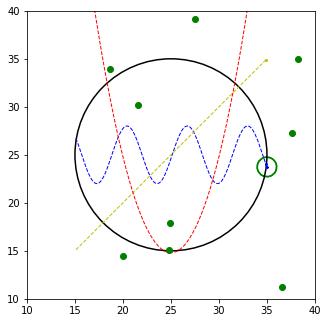

In [35]:
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(10, 40), ylim=(10, 40))

real_point1, = ax.plot([], [], 'bo', ms=2)
real_point2, = ax.plot([], [], 'yo', ms=2)
real_point3, = ax.plot([], [], 'ro', ms=2)
rand_point, = ax.plot([], [], 'go', ms=2)
# obs_list_anim = np.array(obs_list)
line1, = ax.plot([], [], '--', lw=1, color = 'b')
line2, = ax.plot([], [], '--', lw=1, color = 'y')
line3, = ax.plot([], [], '--', lw=1, color = 'r')

real_point1_est, = ax.plot([], [], 'b*', ms=2)
real_point2_est, = ax.plot([], [], 'y*', ms=2)
real_point3_est, = ax.plot([], [], 'r*', ms=2)

# sensor_fov_draw_circle = plt.Circle((sensor_pos[0], sensor_pos[1]), shape[1], fill = False)


rand_point, = ax.plot([], [], 'go', ms=6)
obs_list_anim = np.array(obs_list)

time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    """initialize animation"""
    
    real_point1.set_data([], [])
    real_point2.set_data([], [])
    real_point3.set_data([], [])

    real_point1_est.set_data([], [])
    real_point2_est.set_data([], [])
    real_point3_est.set_data([], [])


    rand_point.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    
#     ax.add_artist(sensor_fov_draw_circle)
    return real_point1, real_point2, real_point3, rand_point, line1, line2, line3, real_point1_est, real_point2_est, real_point3_est

def animate(i):
    """perform animation step"""
    global dt, ax, fig
    
    
    x, y = [], []
    for point in jpda_est[i]:
        x.append(point[0, 0])
        y.append(point[1, 0])
    real_point1_est.set_data(x, y)


    # update pieces of the animation
    if inside_time_interval(i*dt + dt, traj[0]['time_interval']):
        index = int((i*dt - traj[0]['time_interval'][0])/dt)
        real_point1.set_data(traj[0]['points'][index][0], traj[0]['points'][index][1])
        line1.set_data(15 + traj[0]["time_range"], 3 * np.sin(15 + traj[0]["time_range"]) + 25)
    
    if inside_time_interval(i*dt + dt, traj[1]['time_interval']):
        index = int((i*dt - traj[1]['time_interval'][0])/dt)
        
        real_point2.set_data(traj[1]['points'][index][0], traj[1]['points'][index][1])
        line2.set_data(15 + traj[1]["time_range"], 15 + traj[1]["time_range"])
    
    if inside_time_interval(i*dt + dt, traj[2]['time_interval']):
        index = i - int(traj[2]['time_interval'][0]*10) + 1
        
        real_point3.set_data(traj[2]['points'][index][0], traj[2]['points'][index][1])
        line3.set_data(15 + traj[2]["time_range"], 0.4 * (15 + traj[2]["time_range"] - 25)**2 + 14.8)
    
    
    x , y = [], []
    for point in noise[i]:
        
        x.append(point[0])
        y.append(point[1])
    rand_point.set_data(x, y)
    
    #patches = []
    for obj in ax.findobj(match = Ellipse):
        obj.remove()
    for gates in ellips_inputs[i]:
        mu = [gates[1][0,0], gates[1][1,0]]
        S = gates[0]
        e = make_ellipse(mu, S, gating_size)
        ax.add_artist(e)
    
    fov = Ellipse(sensor_pos, 2*shape[1], 2*shape[1], facecolor='none',
                  edgecolor='black',
                  #ls='dashed',  #for debugging
                  lw=1.5)
    
    ax.add_artist(fov)
    
    return real_point1, real_point2, real_point3, rand_point, real_point1_est, real_point2_est, real_point3_est#, time_text, patches

ani = animation.FuncAnimation(fig, animate, frames=len(jpda_est),
                              interval=10, blit=True, init_func=init, repeat = False)

ani.save('video/jpda_FoV_filtered.mp4', fps=20)

In [ ]:
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0, 50), ylim=(0, 50))

real_point1, = ax.plot([], [], 'bo', ms=8)
real_point2, = ax.plot([], [], 'yv', ms=8)
real_point3, = ax.plot([], [], 'r*', ms=8)
rand_point, = ax.plot([], [], 'go', ms=6)
# obs_list_anim = np.array(obs_list)
line1, = ax.plot([], [], '--', lw=1, color = 'b')
line2, = ax.plot([], [], '--', lw=1, color = 'y')
line3, = ax.plot([], [], '--', lw=1, color = 'r')
sensor_fov_draw_circle = plt.Circle((sensor_pos[0], sensor_pos[1]), shape[1][0], fill = False)


def init():
    """initialize animation"""
    
    real_point1.set_data([], [])
    real_point2.set_data([], [])
    real_point3.set_data([], [])
    rand_point.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    
    
    ax.add_patch(sensor_fov_draw_circle)
    return real_point1, real_point2, real_point3, rand_point, line1, line2, line3

def animate(i):
    """perform animation step"""
    global dt, ax, fig
    

#     ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
#              / np.diff(ax.get_xbound())[0])

    
    # update pieces of the animation
    if inside_time_interval(i*dt + dt, traj[0]['time_interval']):
        index = int((i*dt - traj[0]['time_interval'][0])/dt)
        real_point1.set_data(traj[0]['points'][index][0], traj[0]['points'][index][1])
        line1.set_data(15 + traj[0]["time_range"], 3 * np.sin(15 + traj[0]["time_range"]) + 25)
    
    if inside_time_interval(i*dt + dt, traj[1]['time_interval']):
        index = int((i*dt - traj[1]['time_interval'][0])/dt)
        
        real_point2.set_data(traj[1]['points'][index][0], traj[1]['points'][index][1])
        line2.set_data(15 + traj[1]["time_range"], 15 + traj[1]["time_range"])
    
    if inside_time_interval(i*dt + dt, traj[2]['time_interval']):
        index = i - int(traj[2]['time_interval'][0]*10) + 1
        
        real_point3.set_data(traj[2]['points'][index][0], traj[2]['points'][index][1])
        line3.set_data(15 + traj[2]["time_range"], 0.4 * (15 + traj[2]["time_range"] - 25)**2 + 13)
    